In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data
DS = np.loadtxt('Dispersedpulses.txt', delimiter=',')

In [3]:
print(DS.shape)

(1000, 256)


In [4]:
# Observing parameters
bw = 16.5
nchan = 256
f_center = 326.5
f_res = bw/nchan

In [5]:
# Calculate frequency range
def freq_value(n_chan, f_cent, f_res):
    
        hfreq = f_cent + bw/2
        freqs = []
        
        for i in range(n_chan):
            freqs.append(hfreq - (i*f_res)) 
        
        return np.array(freqs)

In [6]:
freqs = freq_value(nchan, f_center, f_res)

In [7]:
# Try to increase frequency resolution
# Reduce 64 channels == sum every 4 f channels
reduce = []

for i in range(0, len(DS.transpose()), 4):          
    a = DS.transpose()[i:i+4]
    reduce.append(np.sum(a, axis = 0))
reduce = np.array(reduce)

In [8]:
reduce.shape

(64, 1000)

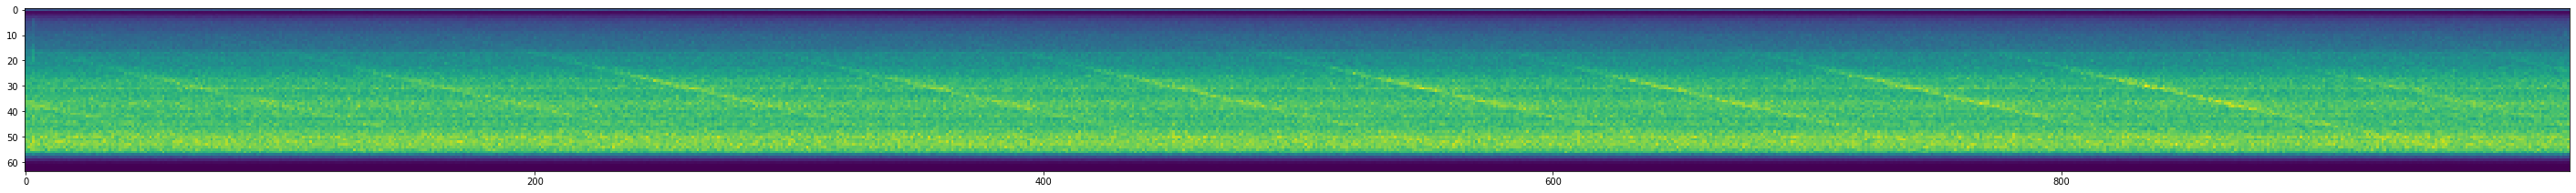

In [9]:
plt.figure(figsize=[50,70])
plt.imshow(reduce)

In [10]:
# We will fit a gaussian on those 5 data
chans = [26,33,39]
Mydict = {}
for i in range(len(chans)):
    Mydict[i] = reduce[chans[i]][800:900] 

In [11]:
for i in range(len(Mydict)):
    Mydict[i] = (Mydict[i] - Mydict[i].mean())/Mydict[i].std()

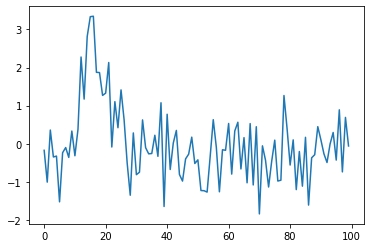

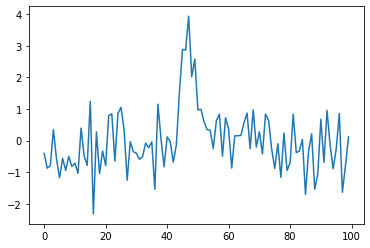

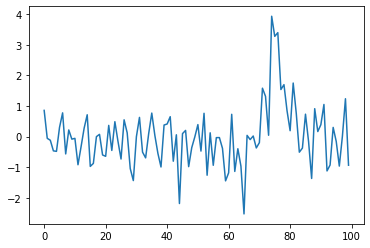

In [12]:
# Visulalize the normalize data
for i in range(len(Mydict)):
    plt.figure()
    plt.plot(Mydict[i])

In [13]:
# Fit with a gaussian curve
from scipy.optimize import curve_fit
def gaussian(x,amp,mu,sigma):
    return amp*np.exp(-(x - mu)**2/(2*sigma**2))

In [14]:
xi = np.arange(len(Mydict[0]))

In [15]:
# Initial guess
guess = [[3,19,5], [4,46,3],[4,76,3]]

In [16]:
params = []
arr = []
for i in range(len(Mydict)):
    prms, pcov = curve_fit(gaussian, xi, Mydict[i], p0=[guess[i]])# p0 = [3, 19, 5])
    params.append(prms)
    arr.append(prms[1])

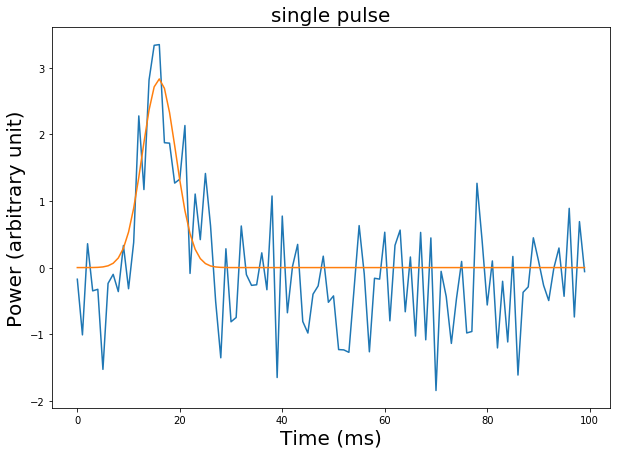

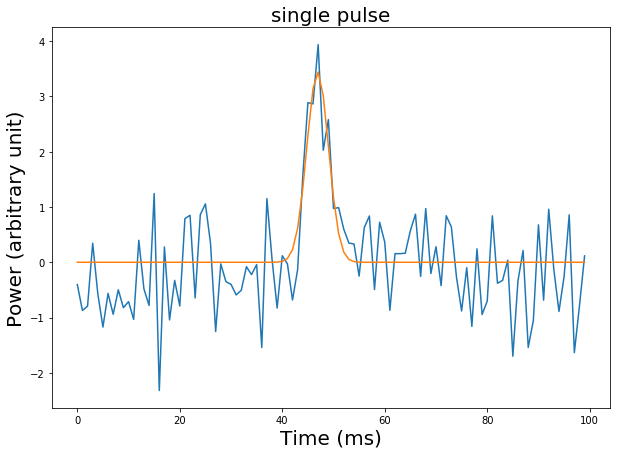

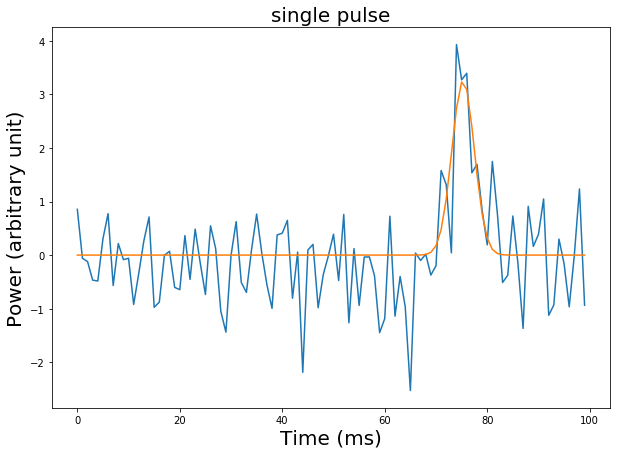

In [17]:
for i in range(len(Mydict)):
    plt.figure(figsize=[10,7])
    plt.title('single pulse', fontsize = 20)
    plt.xlabel('Time (ms)', fontsize = 20)
    plt.ylabel('Power (arbitrary unit)', fontsize = 20)
    plt.plot(Mydict[i])
    prms = params[i]
    ypred = gaussian(xi, prms[0], prms[1], prms[2])
    plt.plot(ypred)

In [18]:
# Calculate new freq value
bw2 = 16.5
nchan2 = 64
fres2 = bw2/nchan2

In [19]:
newfreq = freq_value(nchan2,f_center,fres2)

In [20]:
# Freq for the fitted channels above
fr_fitted = newfreq[chans]

In [21]:
fr_fitted

array([328.046875 , 326.2421875, 324.6953125])

In [22]:
arr

[15.956833550820935, 46.90537051690888, 75.29007823106015]

In [23]:
def slope(f2, f1):

    # convert to Ghz
    lo = f1*1e-3  
    hi = f2*1e-3
        
    return 4.15*(lo**(-2) - hi**(-2))    

In [24]:
index = [[0,1],[0,2],[1,2]]

In [25]:
# Calculate the different arrival time
listarr = []
for i in range(len(index)):
    listarr.append(np.absolute(arr[index[i][0]] - arr[index[i][1]]))

In [26]:
# Calculate the different slope 
listslope = []
for i in range(len(index)):
    
    listslope.append(slope(fr_fitted[index[i][0]], fr_fitted[index[i][1]]))

In [27]:
def line(x, dm):
    return x*dm

In [28]:
prm, popt = curve_fit(line, listslope, listarr)

In [29]:
prm

array([74.10098202])

In [30]:
popt

array([[0.6198935]])

In [31]:
# Dedispersion trials
class dedisp():
    
    def __init__(self, bw, freqs, nchan = 256, t_res = 1):
        
        self.bw = bw
        self.freqs = freqs
        self.f_ref = freqs[0]
        self.nchan = nchan
        self.f_res = self.bw/self.nchan
        self.t_res = t_res
    
    # Calculate time delay in the image
    def time_delay(self, DM, f):
        
        # convert to Ghz
        lo = f*1e-3  
        hi = self.f_ref*1e-3
        
        # calculate delay
        dt = 4.15*(lo**(-2) - hi**(-2))*DM
        
        return np.int(np.round(dt/self.t_res)) 
    
    # Dedisperse 
    # The input frame should be [freq, time]
    def dedisperse(self, frame, DM):
        
        # Calculate all the delay btw each freq channel
        delays = []
        for i in range(len(self.freqs)):
            delays.append(self.time_delay(DM, self.freqs[i]))
        
        frame2 = []
        
        for i in range(len(frame)):
            
                chans = []
                for j in range(600):
                    chans.append(frame[i][j + delays[i]])
                frame2.append(np.array(chans))
                
        return np.array(frame2)
    
    # Time series data
    def timeseries(self, frame):
        return np.sum(frame, axis = 0)
    
    # Mean absolute deviation
    def mad(self, x):
        mu = np.mean(x)
        return np.mean(np.absolute(x - mu))
    
    # Evaluate mad for different dm values
    def evall(self, frame):
        
        mad = []
        # Lets try DM from 0 to 100 spaced by 0.5
        DMs = np.arange(0,100,0.1)
        
        for i in DMs:
            ddisp = self.dedisperse(frame, i)
            ddisp = self.timeseries(ddisp)
            mad.append(self.mad(ddisp))
        
        return DMs, np.array(mad)

In [32]:
process = dedisp(bw,freqs)

### DM trials and MAD evaluation

In [33]:
dms, mads = process.evall(DS.transpose())

In [34]:
# Normalize data
mad1 = (mads - mads.mean())/mads.std()
# Min max
mad2 = (mads - mads.min())/(mads.max() - mads.min()) 

Text(0, 0.5, 'mean absolute deviation')

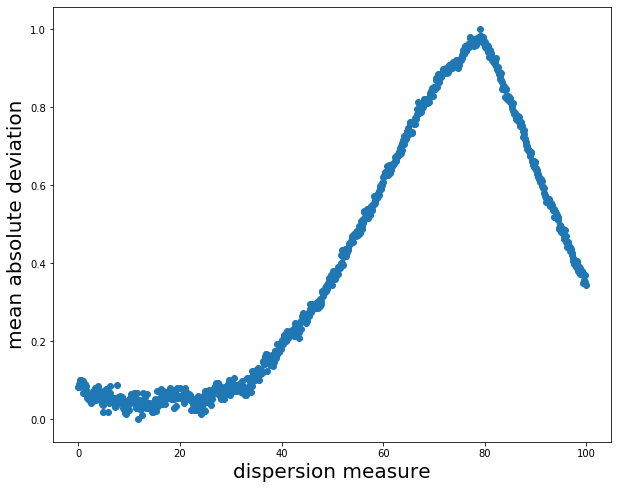

In [35]:
plt.figure(figsize=[10,8])
plt.scatter(dms,mad2)
plt.xlabel('dispersion measure', fontsize = 20)
plt.ylabel('mean absolute deviation', fontsize = 20)

In [36]:
# Fit a gaussian
def gaussian(x,amp,mu,sigm):
    
    return amp*np.exp(-(x-mu)**2/(2*sigm**2))

In [37]:
param1, unc1 = curve_fit(gaussian, dms, mad1, p0=[1.75,62,20])
param2, unc2 = curve_fit(gaussian, dms, mad2, p0=[1,62,20])

In [38]:
print(param1)
print(unc1)
print(param2)
print(unc2)

[ 1.75370274 76.29559142 10.3062976 ]
[[ 0.00364585 -0.00020579 -0.01463068]
 [-0.00020579  0.16756287  0.00292541]
 [-0.01463068  0.00292541  0.17311352]]
[ 0.9087161  75.43768285 18.67752005]
[[ 7.98726836e-06 -2.64230057e-05 -1.40810605e-04]
 [-2.64230057e-05  5.55495157e-03  1.92775792e-03]
 [-1.40810605e-04  1.92775792e-03  6.93669041e-03]]


In [39]:
ypred1 = gaussian(dms, param1[0], param1[1], param1[2])
ypred2 = gaussian(dms, param2[0], param2[1], param2[2])

Text(10, 0.8, '$\\mu$ = 75.44 \n $\\sigma$ = 18.68')

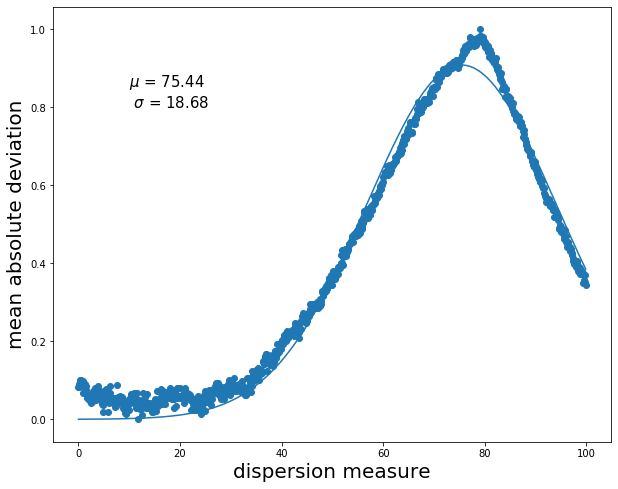

In [40]:
plt.figure(figsize=[10,8])
plt.scatter(dms,mad2)
plt.plot(dms,ypred2)
plt.xlabel('dispersion measure', fontsize = 20)
plt.ylabel('mean absolute deviation', fontsize = 20)
plt.text(10,0.8,'$\mu$ = %.2f \n $\sigma$ = %.2f'%(param2[1], param2[2]), fontsize = 15)

### Dedispersion

In [42]:
dedpulse = process.dedisperse(frame = DS.transpose(), DM = 74.1)
tseries = process.timeseries(dedpulse)

Text(0, 0.5, 'Frequency channels')

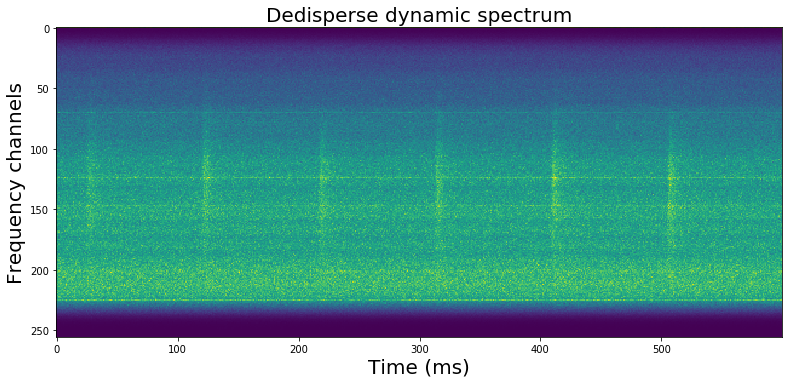

In [46]:
plt.figure(figsize=[13,10])
plt.imshow(dedpulse)
plt.title('Dedisperse dynamic spectrum', fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.ylabel('Frequency channels', fontsize = 20)

Text(0, 0.5, 'Power (arbirary units)')

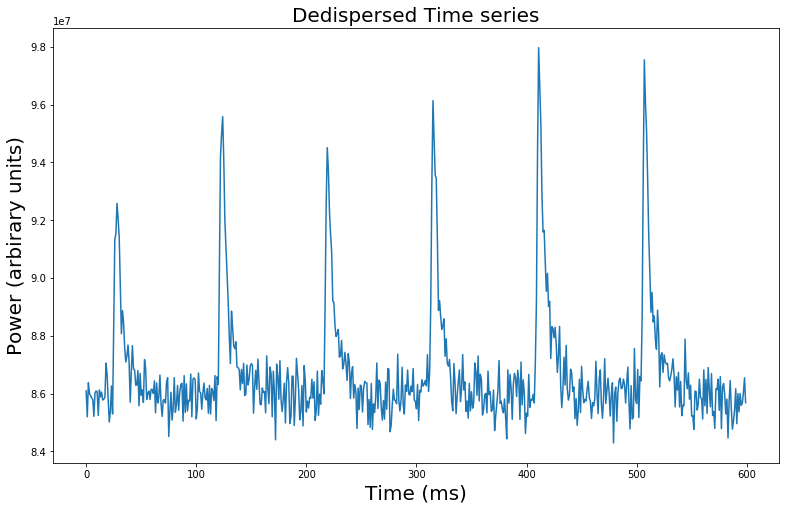

In [50]:
plt.figure(figsize=[13,8])
plt.plot(tseries)
plt.title('Dedispersed Time series', fontsize = 20)
plt.xlabel('Time (ms)', fontsize = 20)
plt.ylabel('Power (arbirary units)', fontsize = 20)

In [51]:
# Calculate arrival time 
# Fit multiple gaussian

In [65]:
tnormal = (tseries - tseries.min())/(tseries.max() - tseries.min())

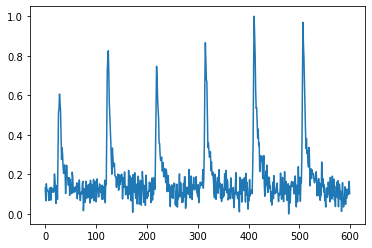

In [66]:
plt.plot(tnormal)

In [67]:
xx = np.arange(100)

In [72]:
params1, popt1 = curve_fit(gaussian, xx, tnormal[0:100], p0 = [0.6,28,10])
params2, popt2 = curve_fit(gaussian, xx, tnormal[100:200], p0 = [0.8,25,10])
params3, popt3 = curve_fit(gaussian, xx, tnormal[200:300], p0 = [0.7,15,10])
params4, popt4 = curve_fit(gaussian, xx, tnormal[300:400], p0 = [0.9,10,10])
params5, popt5 = curve_fit(gaussian, xx, tnormal[400:500], p0 = [1,10,10])
params6, popt6 = curve_fit(gaussian, xx, tnormal[500:600], p0 = [0.95,6,10])

In [85]:
parameters = [params1,params2,params3,params4,params5,params6]

In [86]:
mu = []
for i in range(len(parameters)):
    
    mu.append(parameters[i][1] + i*100)

Text(0, 0.5, 'Arrival time (ms)')

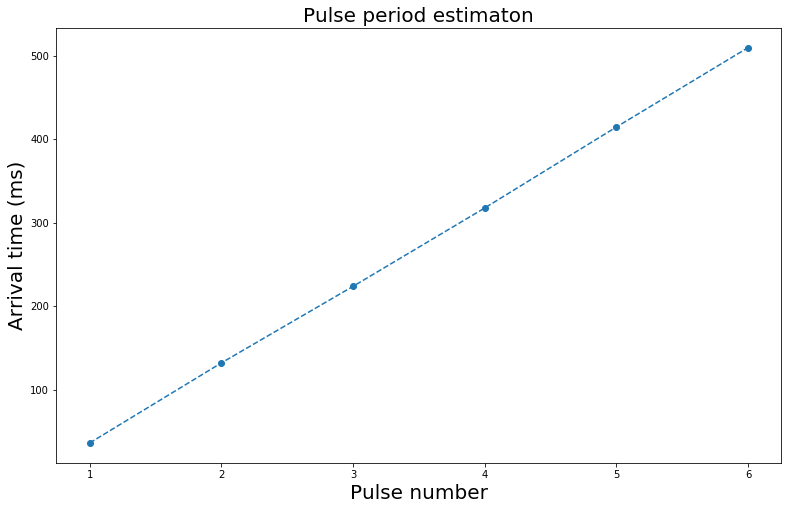

In [94]:
plt.figure(figsize=[13,8])
plt.scatter(np.arange(1,len(mu)+1), mu)
plt.plot(np.arange(1,len(mu)+1), mu, '--')
plt.title('Pulse period estimaton', fontsize = 20)
plt.xlabel('Pulse number',  fontsize = 20)
plt.ylabel('Arrival time (ms)',  fontsize = 20)

In [95]:
# Fit a line 
def linep(x, a, b):
    return a*x + b

In [97]:
parms, uncc = curve_fit(linep, np.arange(1,len(mu)+1), mu)

In [99]:
parms

array([ 94.53092563, -58.58090805])

In [100]:
uncc

array([[ 0.13165076, -0.46077765],
       [-0.46077765,  1.99670311]])